# Sentiment Analysis

This is a basic sentiment analysis model that evaluates the statement between positive and negative statement. These emotions can be further broken down into 'Happy', 'Sad', 'Angry' emotions down the using a similar approach. 

### Importing libraries

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import re

### Natural language processing

nltk - Natural language processing is a collection of libraries for nlp 


stopwords - a collection of words that dont provide any meaning to a sentence 


WordNetLemmatizer – used to convert different forms of words into a single item but still keeping the context intact.\\

In [44]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rithvik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rithvik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Machine learning

scikit learn -  machine learning library

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### Evaluation Metrics 

In [46]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

### Dataset

We will read the dataset (imported from kaggle) and then do some pre-processing

In [47]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [48]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

print("Shape of the DataFrame:",df.shape)
print(df.sample(5))

Shape of the DataFrame: (18000, 2)
                                                    text  label
13856  i love being comfy that is my main goal when i...   fear
9466   i feel that its very romantic and to add to my...   love
12300  im feeling very generous i bought a gift for a...    joy
7939   i feel irritable or depressed during the cours...  anger
16491  i feel like it is a valuable addition to any t...    joy


<Axes: xlabel='count', ylabel='label'>

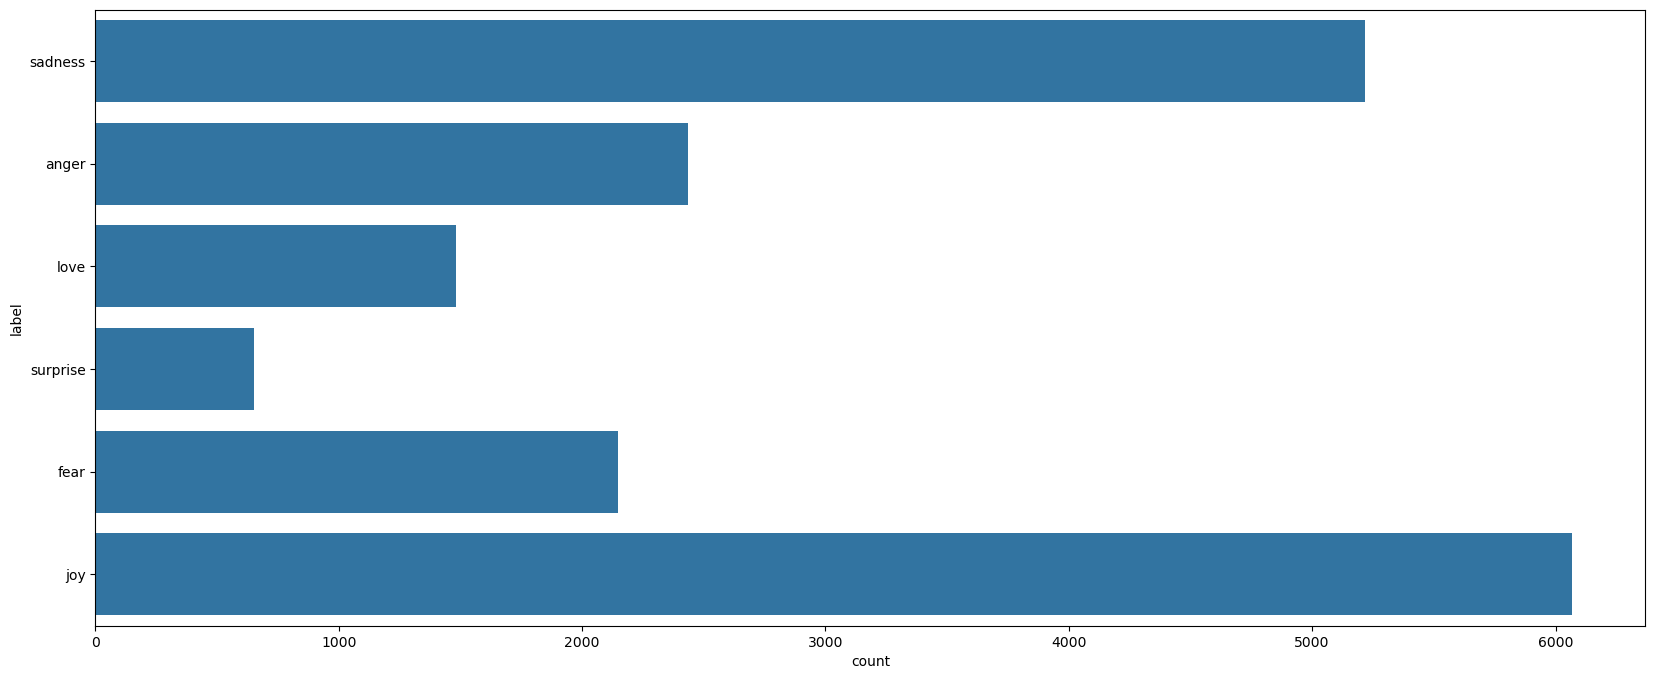

In [49]:
sns.countplot(df.label)

For the sake of simplicity (see multi class sentiment analyser for complex stuff), i will now encode these emotions as positive and negative

In [50]:
def custom_encoder(series):
    return series.replace({
        "surprise": 1,
        "love": 1,
        "joy": 1,
        "fear": 0,
        "anger": 0,
        "sadness": 0
    })

df['label'] = custom_encoder(df['label'])


<Axes: xlabel='label', ylabel='count'>

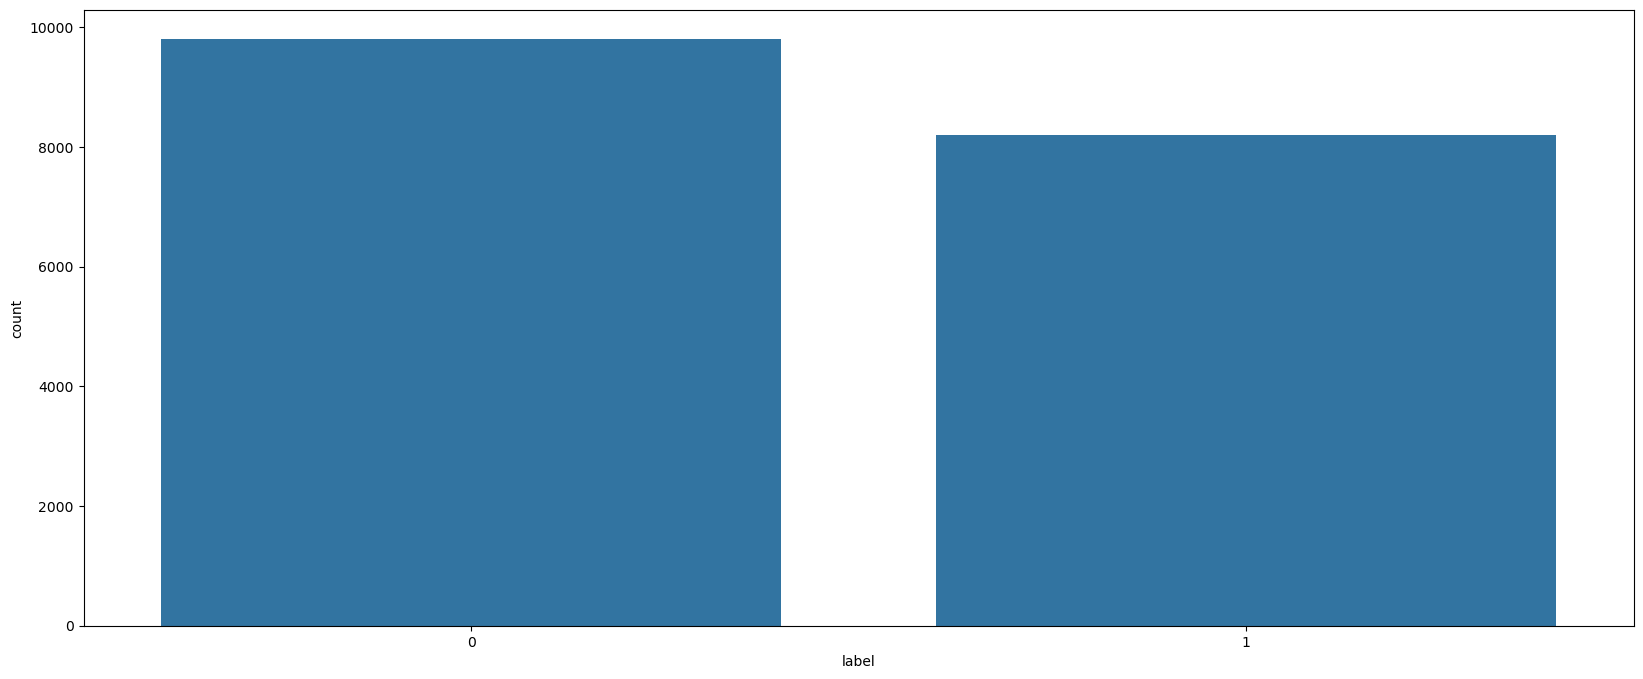

In [51]:
sns.countplot(x=df['label'])

In [52]:
print(df.sample(5))

                                                    text  label
11095  im not down how do you feel about yourself tra...      0
15394  i can still remember what it was like to be a ...      1
7402   i wonder what he thinks about now when he hear...      0
1305   i feel like a post might be devoted to dealing...      1
13700  i feel smart intelligent and then i look at so...      1


#### Pre processing

For pre-processing:

- First, we will iterate through each record, and using a regular expression, we will get rid of any characters apart from alphabets.
- Then, we will convert the string to lowercase as, the word “Good” is different from the word “good”
- Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as “the”, “an”, “to” etc. which do not add much value.
- Then, we will perform lemmatization on each word,i.e. change the different forms of a word into a single item called a lemma.


A lemmatisation transforms a word into its simplest form (lemma) without changing its meaning (context)


For example 'fighting' -> 'fought' -> 'fight'

In [53]:
from nltk.corpus import stopwords
lm = WordNetLemmatizer()

In [54]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [55]:
corpus = text_transformation(df['text'])

#### creating a wordCloud

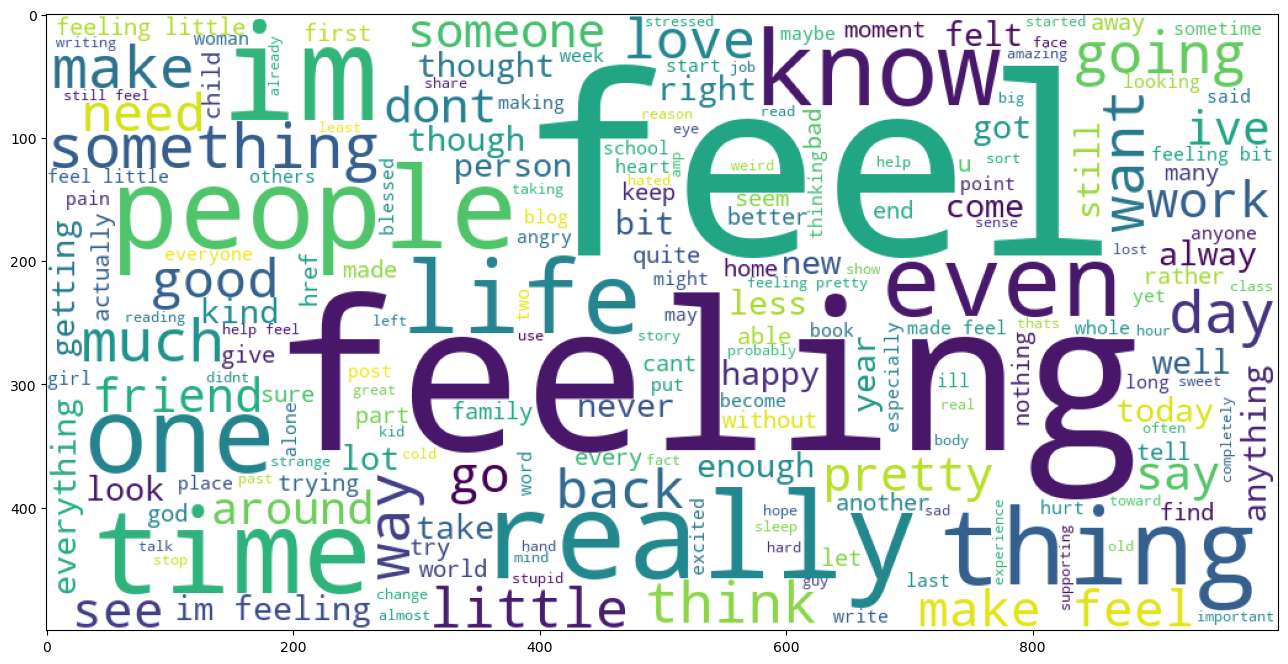

In [56]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

### Bag of Words Model

From above pre-processing we have removed all the semantics in a sentence and reduced it into a 'bag of words' that lends itself meaning.


For example, 'I hate pappaya' -> 'hate' and like so

A key tenant in this model is:


'the grammar and the order of words in a sentence are not given any importance, instead, multiplicity, i.e. (the number of times a word occurs in a document) is the main point of concern.'

Scikit-Learn provides a neat way of performing the bag of words technique using CountVectorizer.

In [57]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

Ngram is a sequence of ‘n’ of words in a row or sentence. ‘ngram_range’ is a parameter, which we use to give importance to the combination of words, such as, “social media” has a different meaning than “social” and “media” separately.

We can experiment with the value of the ngram_range parameter and select the option which gives better results.

### Machine Learning Model

In [58]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

/opt/anaconda3/envs/senti-anal/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
